In [1]:
#!/usr/bin/python

# Import required modules
import os
import sys
sys.path.append('..')
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Utilities
from tools import load_json
import project_utils as utils
import h5py

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Initial setup

In [2]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [3]:
# Load IZA cantons
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
n_iza = len(iza_cantons)

# Linear regression of molar volumes and energies

In [4]:
deem_dir = '../../Processed_Data/DEEM_330k/Data'
iza_dir = '../../Processed_Data/IZA_230/Data'

## Deem 10k train set

In [5]:
# Load train and test set indices for Deem
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_test.idxs', dtype=int)
n_deem_train = len(deem_train_idxs)
n_deem_test = len(deem_test_idxs)

In [6]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
deem_structure_properties = {}
deem_predicted_structure_properties = {}

iza_structure_properties = {}
iza_predicted_structure_properties = {}
for pn in property_names:
    property_label = pn.capitalize()
    
    deem_structure_properties[pn] = np.loadtxt(f'{deem_dir}/structure_{pn}.dat')
    iza_structure_properties[pn] = np.loadtxt(f'{iza_dir}/structure_{pn}.dat')
    
for cutoff in cutoffs:
    deem_predicted_structure_properties[cutoff] = {}
    iza_predicted_structure_properties[cutoff] = {}
    for pn in property_names:
        property_label = pn.capitalize()
        
        deem_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{deem_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties.dat')
        
        iza_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{iza_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties.dat')

In [7]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.39	2.79
IZA:	--	230	--	5.30

IZA1:	--	35	--	4.59
IZA2:	--	126	--	5.14
IZA3:	--	68	--	5.40
IZA4:	--	1	--	44.12

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.59	0.65
IZA:	--	230	--	0.99

IZA1:	--	35	--	1.00
IZA2:	--	126	--	0.88
IZA3:	--	68	--	0.93
IZA4:	--	1	--	19.50

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.02	1.09
IZA:	--	230	--	1.69

IZA1:	--	35	--	0.96
IZA2:	--	126	--	1.55
IZA3:	--	68	--	1.90
IZA4:	--	1	--	29.70

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.08	0.11
IZA:	--	230	--	0.11

IZA1:	--	35	--	0.14
IZA2:	--	126	--	0.08
IZA3:	--	68	--	0.11
IZA4:	--	1	--	1.88



## Deem random train set

In [8]:
# Load train and test set indices for Deem
deem_train_idxs_random = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_train_random.idxs', dtype=int)
deem_test_idxs_random = np.loadtxt('../../Processed_Data/DEEM_330k/ridge_test_random.idxs', dtype=int)
n_deem_train = len(deem_train_idxs_random)
n_deem_test = len(deem_test_idxs_random)

In [9]:
# Set property names for loading
property_names = ['volumes', 'energies']

# Load structure properties
deem_predicted_structure_properties = {}
iza_predicted_structure_properties = {}
    
for cutoff in cutoffs:
    deem_predicted_structure_properties[cutoff] = {}
    iza_predicted_structure_properties[cutoff] = {}
    for pn in property_names:
        property_label = pn.capitalize()
        
        deem_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{deem_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties_random.dat')
        
        iza_predicted_structure_properties[cutoff][pn] = \
            np.loadtxt(f'{iza_dir}/{cutoff}/LRR/{property_label}/lr_structure_properties_random.dat')

In [10]:
for cutoff in cutoffs:
    for pn in property_names:
        property_label = pn.capitalize()
        print(f'-----Error for {cutoff} {property_label}-----')
        print('DATASET | n_train | n_test | train_error | test_error')
        
        deem_train_error = mean_absolute_error(
            deem_structure_properties[pn][deem_train_idxs_random],
            deem_predicted_structure_properties[cutoff][pn][deem_train_idxs_random]
        )
        deem_test_error = mean_absolute_error(
            deem_structure_properties[pn][deem_test_idxs_random],
            deem_predicted_structure_properties[cutoff][pn][deem_test_idxs_random]
        )
        
        iza_test_error = mean_absolute_error(
            iza_structure_properties[pn],
            iza_predicted_structure_properties[cutoff][pn]
        )
        
        print(f'DEEM:\t{n_deem_train}\t{n_deem_test}\t{deem_train_error:.2f}\t{deem_test_error:.2f}')
        print(f'IZA:\t--\t{n_iza}\t--\t{iza_test_error:.2f}')
        print('')
        
        for canton in range(1, np.amax(iza_cantons)+1):
            canton_idxs = np.nonzero(iza_cantons == canton)[0]
            canton_test_error = mean_absolute_error(
                iza_structure_properties[pn][canton_idxs],
                iza_predicted_structure_properties[cutoff][pn][canton_idxs]
            )
            
            print(f'IZA{canton}:\t--\t{len(canton_idxs)}\t--\t{canton_test_error:.2f}')
            
        print('')

-----Error for 3.5 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	2.45	2.41
IZA:	--	230	--	5.06

IZA1:	--	35	--	4.57
IZA2:	--	126	--	4.73
IZA3:	--	68	--	5.23
IZA4:	--	1	--	52.16

-----Error for 3.5 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.62	0.64
IZA:	--	230	--	0.90

IZA1:	--	35	--	0.99
IZA2:	--	126	--	0.85
IZA3:	--	68	--	0.94
IZA4:	--	1	--	2.85

-----Error for 6.0 Volumes-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	1.05	1.05
IZA:	--	230	--	1.63

IZA1:	--	35	--	0.85
IZA2:	--	126	--	1.48
IZA3:	--	68	--	1.86
IZA4:	--	1	--	31.54

-----Error for 6.0 Energies-----
DATASET | n_train | n_test | train_error | test_error
DEEM:	10000	250	0.08	0.12
IZA:	--	230	--	0.11

IZA1:	--	35	--	0.15
IZA2:	--	126	--	0.10
IZA3:	--	68	--	0.11
IZA4:	--	1	--	0.03



## DEEM 330k analysis

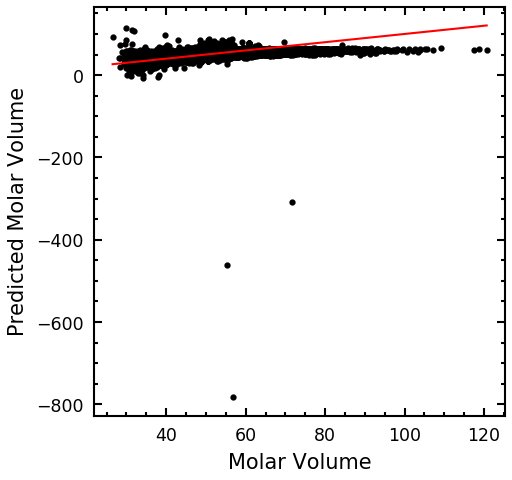

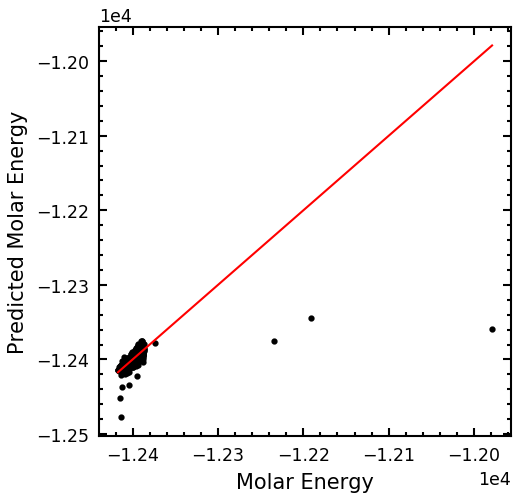

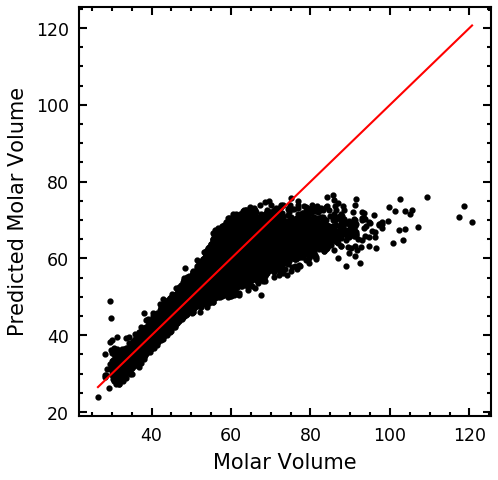

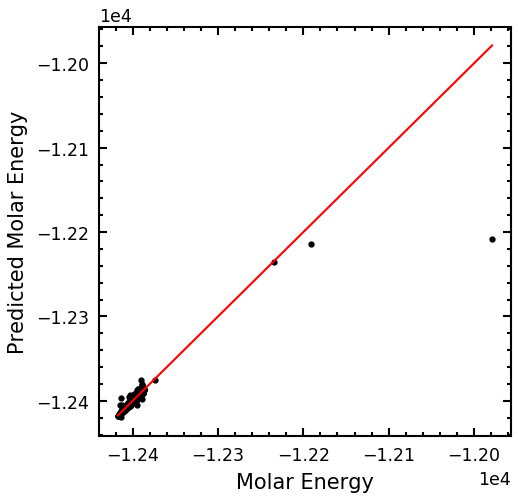

In [11]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        plt.scatter(
            deem_structure_properties[pn], 
            deem_predicted_structure_properties[cutoff][pn]
        )
        plt.plot(
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            [
                deem_structure_properties[pn].min(), 
                deem_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.show()

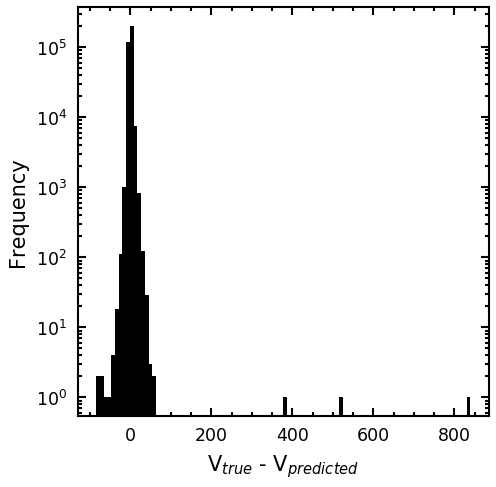

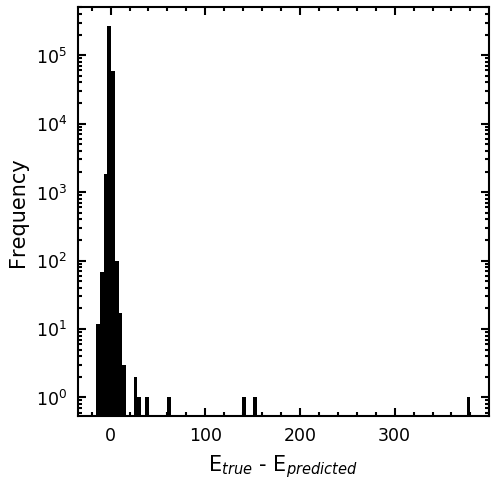

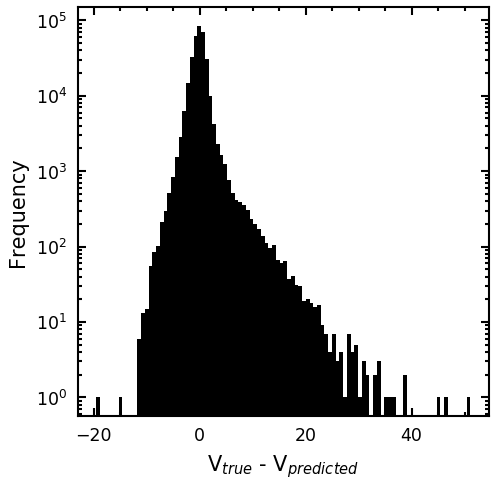

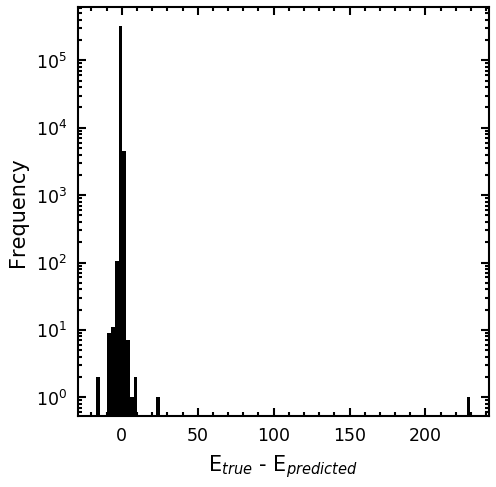

In [12]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [13]:
deem_codes = np.arange(0, len(deem_structure_properties['volumes'])) + 8000001

In [14]:
n_show = 100
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c in zip(errors[idxs][-n_show:], deem_codes[idxs][-n_show:]):
            print(f'{c}\t\t{e}')
        print('')

-----Abs. errors for 3.5 Volumes-----
8309325		30.034879520439127
8301757		30.04222108229552
8305242		30.107511876270394
8068129		30.2918078015868
8285459		30.350274083201825
8056798		30.36256863100543
8037822		30.36543712225096
8248695		30.366463863396476
8292620		30.382841713925494
8328225		30.38831029124495
8267043		30.436642075437547
8079879		30.446390484299542
8325400		30.531207888506096
8327932		30.67973768414098
8316033		30.777835727067917
8317652		30.891425314978733
8129594		30.899556187806915
8307137		31.09958673531552
8274922		31.38149377970759
8307691		31.566442813480577
8325055		31.672577024653954
8308288		31.763630954440018
8329775		31.873156743046096
8318835		31.920871661898182
8319194		31.961525362591132
8312657		32.14007302100781
8116204		32.38176046326874
8323191		32.389709942731876
8200851		32.41482756116717
8320103		32.49831000375515
8327293		32.638631152275096
8295487		32.884517248652344
8307129		32.88959085631459
8261270		32.978906305655826
8326900		33.268308305083

In [15]:
deem_10k_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)
deem_delete_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [16]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(deem_structure_properties[pn] - deem_predicted_structure_properties[cutoff][pn])
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        print(f'-----Problem structures for {cutoff} {pn}-----')
        for i in range(1, 11):
            idxs_high = np.nonzero(errors >= mean_error + i * std_error)[0]
            idxs_low = np.nonzero(errors <= mean_error - i * std_error)[0]
            idxs_all = np.concatenate((idxs_low, idxs_high))
            in_deem_10k = np.intersect1d(deem_10k_idxs, idxs_all)
            in_deem_delete = np.intersect1d(deem_delete_idxs, idxs_all)
            for idxs in (idxs_all, in_deem_10k, in_deem_delete):
                idxs += 8000001
            print(f'{i}-sigma ({len(idxs_all)}, {len(in_deem_delete)}, {len(in_deem_10k)})')
            print(idxs_all)
        print('')

-----Problem structures for 3.5 volumes-----
1-sigma (28553, 3, 815)
[8000008 8000022 8000028 ... 8331161 8331163 8331164]
2-sigma (8495, 3, 247)
[8000022 8000070 8000097 ... 8331136 8331156 8331164]
3-sigma (3504, 3, 97)
[8000022 8000070 8000202 ... 8331120 8331121 8331135]
4-sigma (1786, 3, 58)
[8000022 8001711 8002048 ... 8331020 8331110 8331121]
5-sigma (932, 3, 33)
[8001711 8003329 8004390 8007299 8009564 8014803 8016387 8022741 8024204
 8025529 8026995 8027927 8028083 8035895 8036417 8037822 8037824 8037968
 8038063 8038078 8038136 8038164 8038284 8038300 8038314 8042929 8044737
 8045218 8045577 8045578 8045580 8047564 8047801 8048032 8050952 8052218
 8054009 8054159 8054161 8055726 8055842 8055999 8056680 8056796 8056798
 8056809 8056820 8056830 8056864 8059332 8059343 8059483 8059484 8059805
 8060366 8060369 8060378 8062817 8062865 8063080 8067891 8067892 8067893
 8067909 8068089 8068097 8068112 8068115 8068129 8069913 8077929 8078021
 8078124 8079810 8079879 8079884 8082032 80

## IZA 230 analysis

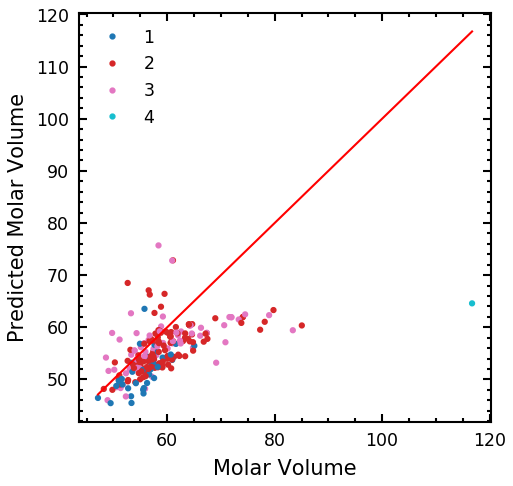

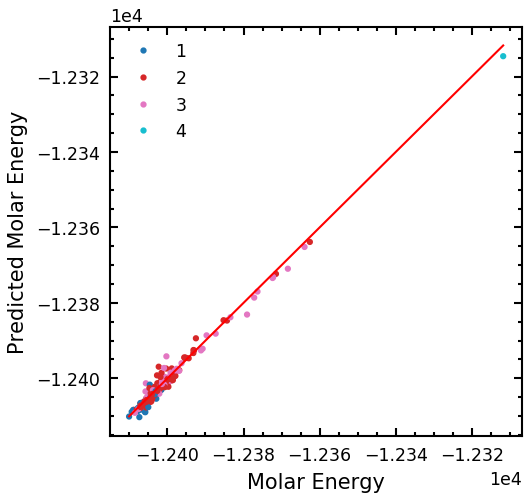

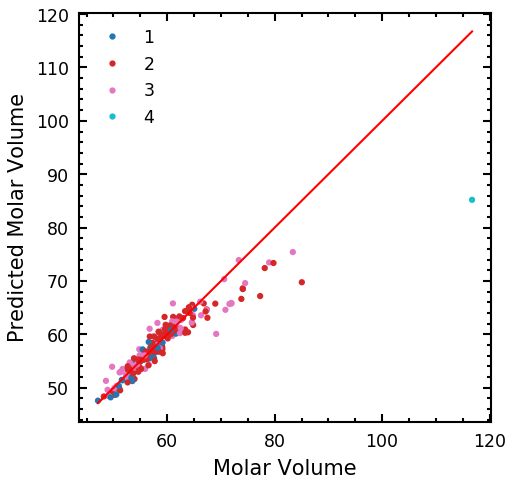

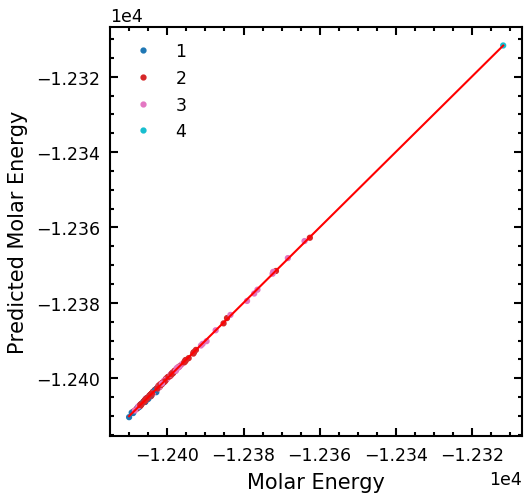

In [17]:
for cutoff in cutoffs:
    for pn, label in zip(property_names, ('Volume', 'Energy')):
        scatter = plt.scatter(
            iza_structure_properties[pn], 
            iza_predicted_structure_properties[cutoff][pn],
            c=iza_cantons, cmap='tab10'
        )
        plt.plot(
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            [
                iza_structure_properties[pn].min(), 
                iza_structure_properties[pn].max()
            ], 
            c='r'
        )
        plt.xlabel(f'Molar {label}')
        plt.ylabel(f'Predicted Molar {label}')
        plt.legend(*scatter.legend_elements())
        plt.show()

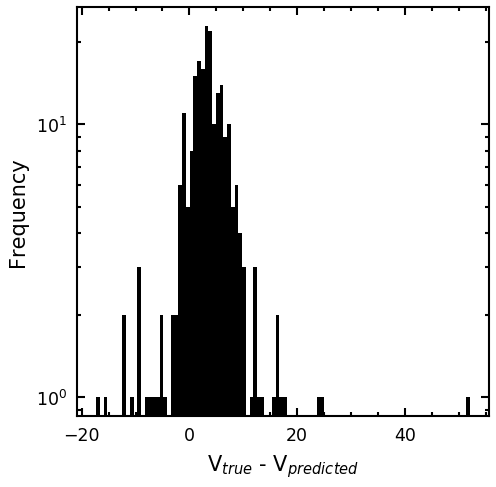

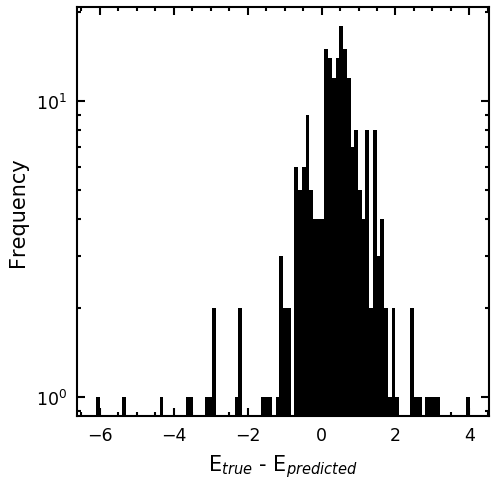

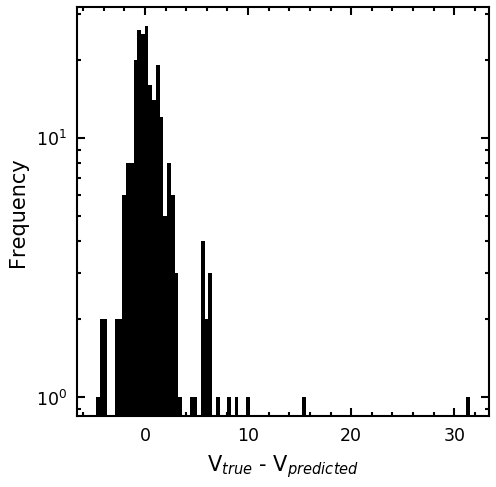

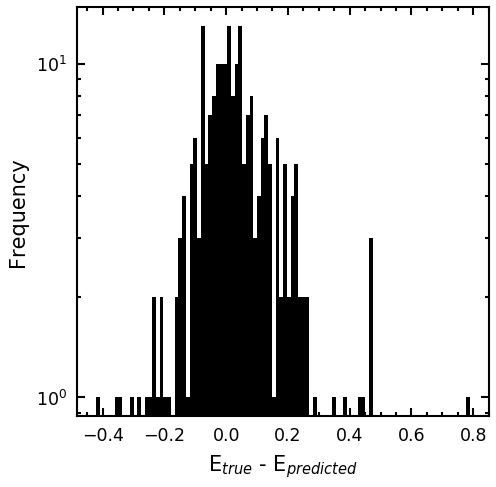

In [18]:
for cutoff in cutoffs:
    for pn in property_names:
        plt.hist(
            iza_structure_properties[pn] - iza_predicted_structure_properties[cutoff][pn],
            bins=100, density=False, log=True
        )
        label = pn.capitalize()[0]
        plt.xlabel(fr'{label}$_{{true}}$ - {label}$_{{predicted}}$')
        plt.ylabel('Frequency')
        plt.show()

In [19]:
iza_codes = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=0, dtype=str)

In [20]:
for cutoff in cutoffs:
    for pn in property_names:
        errors = np.abs(iza_structure_properties[pn] -  iza_predicted_structure_properties[cutoff][pn])
        idxs = np.argsort(errors)
        print(f'-----Abs. errors for {cutoff} {pn.capitalize()}-----')
        for e, c, cc in zip(errors[idxs], iza_cantons[idxs], iza_codes[idxs]):
            print(f'{c}\t{cc[0:3]}\t{e}')
        print('')

-----Abs. errors for 3.5 Volumes-----
2	BRE	0.007067356339128139
2	MVY	0.02135581950889076
2	PHI	0.12466503376236204
2	SOR	0.13244388800440277
1	ETL	0.14807920876550185
2	STI	0.1748187437648383
2	JBW	0.31625055093162757
3	DFT	0.40894250675785315
2	SOF	0.5076863848931765
3	SIV	0.5917304294049544
3	POR	0.6442281435165214
2	MRT	0.651839641563825
1	MTF	0.6694618859238588
2	LTL	0.6788570667556257
2	ABW	0.7317141782988514
2	ETV	0.826680677413016
2	LAU	0.8434092226919887
2	MSO	0.8504587285579888
3	BOF	0.8782164615613013
2	SZR	0.9169549510113271
2	LTJ	0.9284872524286527
2	MOZ	0.9806773837416998
2	CAS	0.981734295195281
1	LTF	1.0045217254635546
3	AHT	1.0228068007225843
3	ATT	1.0452613769465557
2	LOV	1.0788831756703559
2	GIS	1.0877243232304679
3	APC	1.0952352075156924
2	VNI	1.1008477506686987
2	MWF	1.105983123544192
3	JRY	1.1553222496584112
3	ATN	1.2218712533014582
3	AFN	1.2452157778147281
1	NSI	1.2954790594937293
3	ACO	1.2967740183585406
3	ZON	1.3031165419208435
3	JSN	1.3575485848367919
2	MAZ	1.